## Ovrlpy

Analyze the VSI across the tissue section using `ovrlpy-0.2.1`  

**Tool**: `ovrlpy-0.2.1`  
**Data Link**: [Supplemental Data for: Segmentation-free inference of cell types from in situ transcriptomics data](https://zenodo.org/records/3478502)  

In this notebook, we focus on analyzing the [mouse hypothalamus data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248) (Moffitt et al., 2018) using `ovrl.py` with a specific modification:  
- **transcripts from MOD1 subtype-specific marker genes are excluded** 
  
in order to explore how their removal affects the VSI.

### packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ovrlpy

### load the data

#### load the data and define settings and input files

merfish_barcodes_example.csv contains 3739360 rows and 13 columns:  
- Gene_name: Gene  
- Cell_name:   
- Animal_ID: 1  
- Bregma: -0.24  
- Animal_sex: Female  
- Behavior: Naive  
- Centroid_X: the x coordinate  
- Centroid_Y: the y coordinate  
- Centroid_Z: the z coordinate  
- Total_brightness:  
- Area:  
- Error_bit:  
- Error_direction:  

In [2]:
data_folder_path = Path(
    "../data/mouse_hypothalamus/MERFISH/"
)

result_folder = Path("../data/results/VSI")
result_folder.mkdir(exist_ok=True, parents=True)

In [3]:
columns = [
    "Centroid_X",
    "Centroid_Y",
    "Centroid_Z",
    "Gene_name",
    "Cell_name",
    "Total_brightness",
    "Area",
    "Error_bit",
    "Error_direction",
]

coordinate_df = pd.read_csv(
    data_folder_path / "merfish_barcodes_example.csv", usecols=columns
).rename(
    columns={
        "Centroid_X": "x",
        "Centroid_Y": "y",
        "Centroid_Z": "z",
        "Gene_name": "gene",
    }
)

# remove dummy molecules
coordinate_df = coordinate_df.loc[
    ~coordinate_df["gene"].str.contains("Blank|NegControl"),
]

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

# shift the coordinates to avoid the negative values
coordinate_df['x'] = coordinate_df['x'] - coordinate_df['x'].min()
coordinate_df['y'] = coordinate_df['y'] - coordinate_df['y'].min()

# make a copy to avoid SettingWithCopyWarning
coordinate_df = coordinate_df.copy()

In [4]:
DE_genes = ['Mbp', 'Lpar1', 'Trh', 'Ucn3', 'Cck']

non_MOD1_marker = coordinate_df[~coordinate_df['gene'].isin(DE_genes)]
non_MOD1_marker = non_MOD1_marker.copy()

### Run the ovrlpy pipeline
fit an ovrlpy model to the data and create a signal integrity map

In [5]:
# define ovrlpy analysis parameters
n_components = 15

In [6]:
# fit the ovrlpy model to the data
dataset = ovrlpy.Ovrlp(
    non_MOD1_marker,
    n_components=n_components,
    n_workers=8,  # number of threads to use for processing
)

dataset.analyse()

Running vertical adjustment
Creating gene expression embeddings for visualization
determining pseudocells
found 3905 pseudocells
sampling expression:


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Modeling 15 pseudo-celltype clusters;


d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Creating signal integrity map


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


In [7]:
# save the signal integrity and strength for subsequent analysis
integrity = dataset.integrity_map
signal = dataset.signal_map

np.savetxt(result_folder/'SignalIntegrity_exMOD1.txt', integrity)
np.savetxt(result_folder/'SignalStrength_exMOD1.txt', signal)

### Visualize results
visualize the data

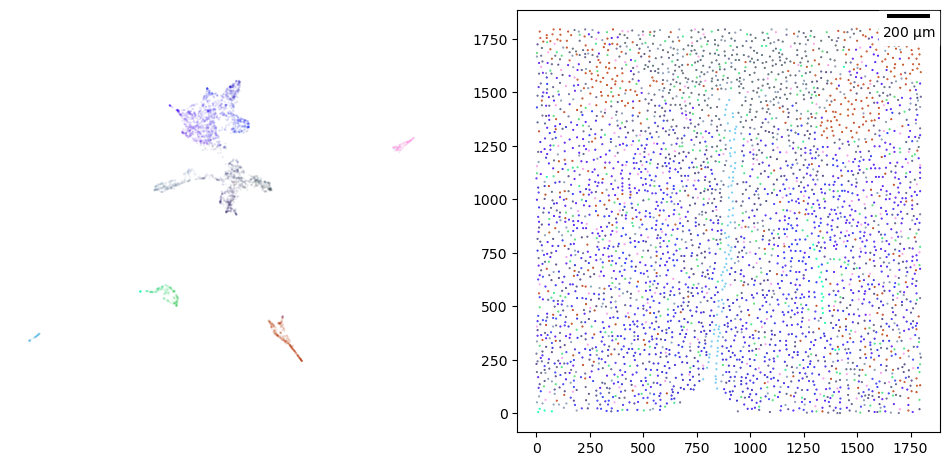

In [8]:
fig = ovrlpy.plot_pseudocells(dataset)

The signal integrity map can be visualized, where visualization is cut off at regions below a certain signal strength threshold:

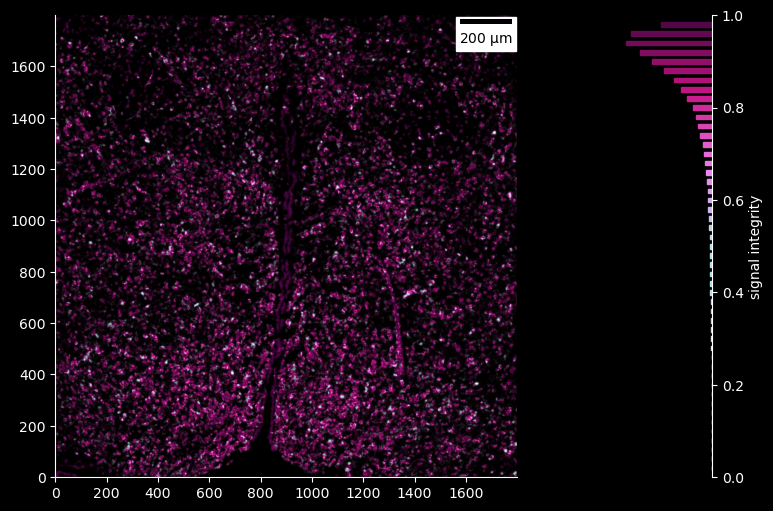

In [9]:
fig = ovrlpy.plot_signal_integrity(dataset, signal_threshold=3)

### Detecting doublets
We can detect individual doublet events with ovrlpy, again setting a signal strength threshold to filter out low-transcript regions:

In [10]:
doublets = dataset.detect_doublets(min_signal=3, # Minimum signal value for a peak to be considered
                                   integrity_sigma=1) # Optional sigma value for gaussian filtering of the integrity map, 
                                                      # which leads to the detection of overlap regions with larger spatial extent.

In [11]:
doublets.write_csv(result_folder / "doublets_exMOD1_df.csv")

And plot a multi-view visualization of the overlaps in the tissue:

In [12]:
window_size = 60

d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\miniconda\envs\ovrlpy_0513\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


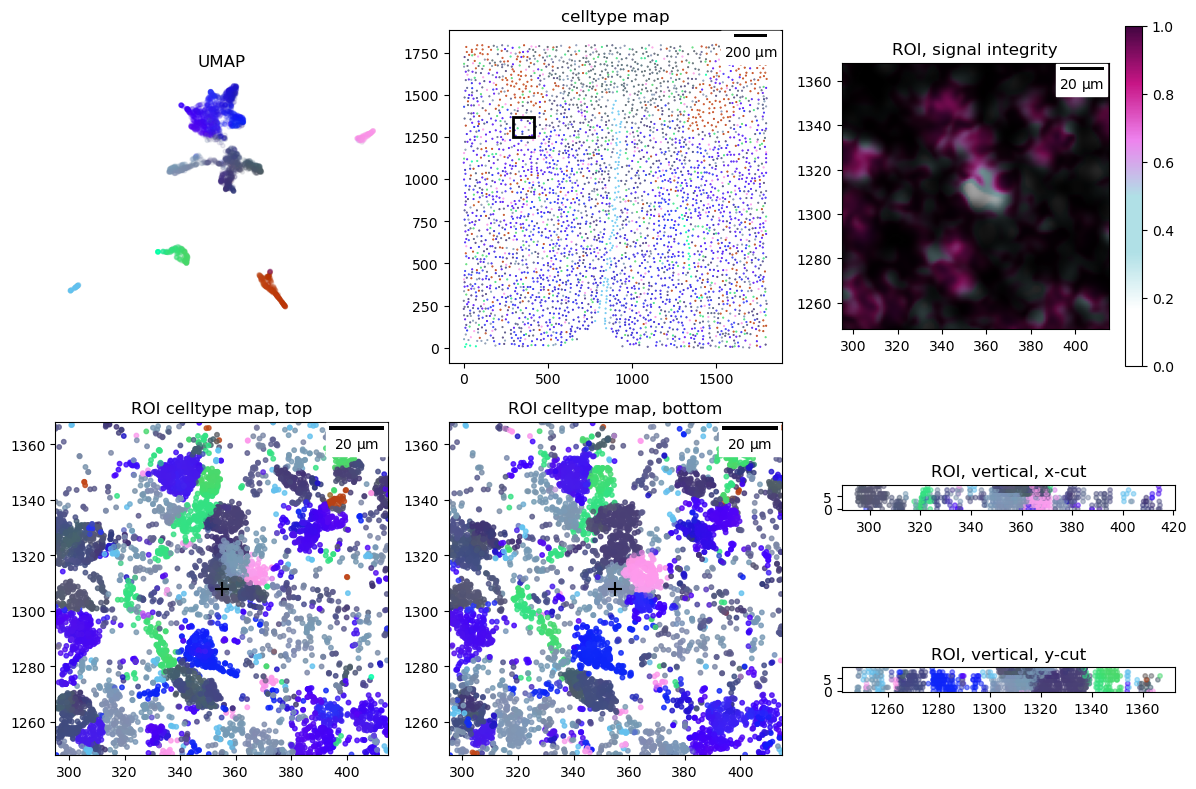

In [13]:
doublet_to_show = 0

x, y = doublets["x", "y"].row(doublet_to_show)

fig = ovrlpy.plot_region_of_interest(dataset, x, y, window_size=window_size)